# Spam Detection With CNN

# 1) Data Preprocessing

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [3]:
df = pd.read_csv('/content/spam.csv',encoding = 'ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop garbage column
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis =1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#rename the column
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# create binary labels (0 and 1)
df['b_labels'] = df['labels'].map({'ham': 0, 'spam':1}) # create a new column as "b_labels"
y = df['b_labels'].values

In [11]:
#split the data
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size = 0.33)

In [13]:
# convert sentences to sequences

max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [14]:
# check word index mapping (to check the number of words in vocabulary)
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens are %s' %V)

Total number of unique tokens are 7247


In [15]:
# pad sequences (to get N x T matrix)
data_train = pad_sequences(sequences_train)
print('shape of data train tensor: ', data_train.shape)

# N: number of samples and T: Number of time steps

shape of data train tensor:  (3733, 189)


In [16]:
data_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 35, 28, 17,  4,
       56, 61], dtype=int32)

In [18]:
# set the value of T to get sequence length
T = data_train.shape[1]

In [19]:
print(T)

189


In [20]:
# pad the test set
data_test = pad_sequences(sequences_test, maxlen=T)
#maxlen = T, to truncate longer sentences in test set
print('shape of data train tensor: ', data_train.shape)


shape of data train tensor:  (3733, 189)


# Building the Model

In [22]:
# Create the model

# Choose embedding dimesionality
D = 20 # this is a hyper parameter, we can choose any word vector size that we want

# input layer
i = Input(shape=(T,)) # input layer takes in sequences of integers, so shape is T

# Embedding layer
x = Embedding(V + 1, D)(i) # This takes in sequences of integers and returns sequences of word vectors
# This will be an N * T * D array
# we want size of embedding to (V + 1) x D, because first word index starts from 1 and not 0

# Conv1D Arguments

# 1. filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
# 2. kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
# 3. activation: Activation function to use. If you don't specify anything, no activation is applied ( see keras.activations).

#  First CNN layer
x = Conv1D(32, 3, activation='relu')(x) # filters,kernel_size,activation
x = MaxPooling1D(3)(x)

# Second CNN layer
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)

# Third CNN layer
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# Dense layer
x = Dense(1, activation='sigmoid')(x) #units =1  , sigmoid: 로지스틱 함수  , 참고사이트 - https://han-py.tistory.com/207

model = Model(i, x)


In [23]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
r = model.fit(x=data_train, y=y_train, epochs=5, validation_data=(data_test, y_test))

Epoch 1/5
117/117 [==============================] - 4s 22ms/step - loss: 0.3882 - accuracy: 0.8661 - val_loss: 0.2873 - val_accuracy: 0.8657
Epoch 2/5
117/117 [==============================] - 3s 25ms/step - loss: 0.1451 - accuracy: 0.9392 - val_loss: 0.1368 - val_accuracy: 0.9685
Epoch 3/5
117/117 [==============================] - 3s 28ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 0.0561 - val_accuracy: 0.9848
Epoch 4/5
117/117 [==============================] - 3s 22ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0653 - val_accuracy: 0.9848
Epoch 5/5
117/117 [==============================] - 2s 19ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0812 - val_accuracy: 0.9831


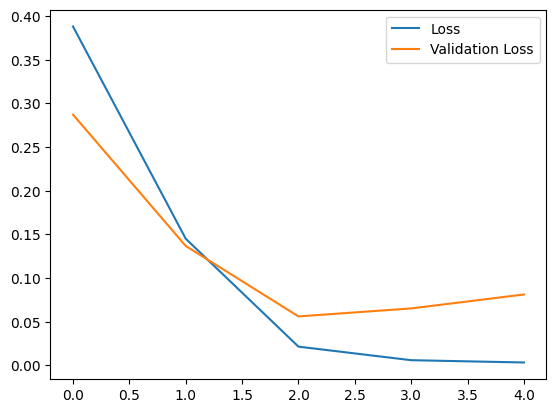

In [25]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

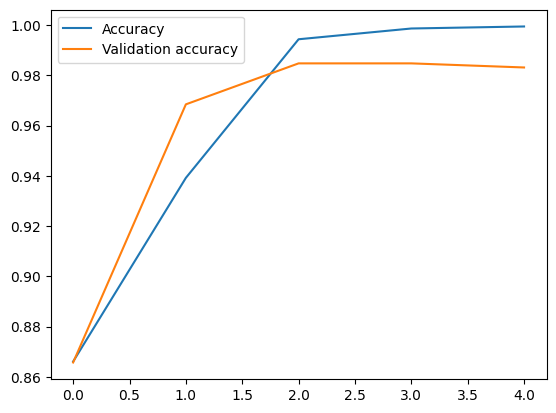

In [26]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()